In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
from scipy import stats
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3)
def custom_ctcklbls(x, pos):
    '''Custom format for colorbar tick labels'''
    return '{:1.1f}'.format(x)
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Choose variable
dir_var = 'nox'
str_var = '$NO_x$'
coeff_no = (28.97/30.006)*1e9 # coeff to convert mass mixing ratio to volume mixing ratio where M dry air = 28.97 [g mol-1]
coeff_no2 = (28.97/46.006)*1e9
# Choose jobs
base_job = 'xojnd'; base_exp = 'BASE'
sens_job = 'xojnc'
if sens_job == 'xojne': sens_exp = 'CHEM';
elif sens_job == 'xojnb': sens_exp = 'OCEAN';
elif sens_job == 'xojnc': sens_exp = 'BB';
elif sens_job == '??': sens_exp = 'ALL'
# Read data
base_plt = base_exp; sens_plt = sens_exp 
path_to_ukca = Path('../data')
base_no = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_chem.pp'), 'mass_fraction_of_nitrogen_monoxide_in_air')*coeff_no
sens_no = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_chem.pp'), 'mass_fraction_of_nitrogen_monoxide_in_air')*coeff_no
base_no2 = iris.load_cube(str(path_to_ukca / base_job / f'{base_job}_chem.pp'), iris.AttributeConstraint(STASH='m01s34i152'))*coeff_no2
sens_no2 = iris.load_cube(str(path_to_ukca / sens_job / f'{sens_job}_chem.pp'), iris.AttributeConstraint(STASH='m01s34i152'))*coeff_no2
# Path to figures
path_to_figs = Path('../../../results') / f'{sens_job}-{base_job}' / dir_var
path_to_figs.mkdir(exist_ok=True)

In [31]:
savefig = True
publish = True
if publish:
    mpl.rcParams['xtick.labelsize'] = 25
    mpl.rcParams['ytick.labelsize'] = 25
    mpl.rcParams['axes.titlesize'] = 40
    mpl.rcParams['axes.labelsize'] = 30
    plt.rcParams['font.size'] = 30

In [4]:
base_no2.units = '1'
sens_no2.units = '1'
base = base_no + base_no2
sens = sens_no + sens_no2

### Description of statistical analysis

1. Perform the Shapiro-Wilk test for normality. scipy docs: The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. Wikipedia: if the p-value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p-value is greater than the chosen alpha level, then the null hypothesis that the data came from a normally distributed population can not be rejected. I.e. if p<0.05, data is not normal, if p>0.05, data is normal.
2. Perform paired samples t-test (https://pythonfordatascience.org/paired-samples-t-test-python/) if is data is normally distributed, or Wilcoxon signed-rank test (https://pythonfordatascience.org/wilcoxon-sign-ranked-test-python/) if data is not normally distributed.
2a. scipy docs: Paired samples t-test is a two-sided test for the null hypothesis that 2 related or repeated samples have identical average (expected) values. If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
2b. scipy docs: The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test. Because the normal approximation is used for the calculations, the samples used should be large. A typical rule is to require that n > 20. Currently my n=10...
3. Control false discovery rate. See https://en.wikipedia.org/wiki/False_discovery_rate, https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/, https://www.statisticshowto.datasciencecentral.com/false-discovery-rate/, https://www.statisticshowto.datasciencecentral.com/multiple-testing-problem/

Explanation of the difference between using one sample and paired samples tests: http://benalexkeen.com/comparative-statistics-in-python-using-scipy/

In [5]:
def fdr_threshold(pvalues, alpha=0.05*2):
    '''Compute the FDR threshod after Wilks (2016).
    Credit to https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/'''
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= np.arange(1, n+1) / n * alpha, p, 0))

In [6]:
# Add season and year coordinates
iris.coord_categorisation.add_season(base, 'time', name='season')
iris.coord_categorisation.add_season(sens, 'time', name='season')
iris.coord_categorisation.add_season_year(base, 'time', name='year')
iris.coord_categorisation.add_season_year(sens, 'time', name='year')
str_djf = 'DJF'; str_mam = 'MAM'; str_jja = 'JJA'; str_son = 'SON'

### Zonal seasonal means

In [7]:
# First 10 km
base.coord('level_height').points[0:23]/1000

array([ 0.01999828,  0.08000153,  0.18000136,  0.31999773,  0.49999908,
        0.719997  ,  0.9799999 ,  1.2799994 ,  1.6200038 ,  1.9999963 ,
        2.4200022 ,  2.8799963 ,  3.380004  ,  3.9199996 ,  4.5       ,
        5.1199975 ,  5.7799997 ,  6.479998  ,  7.220002  ,  8.000002  ,
        8.819999  ,  9.680001  , 10.579999  ], dtype=float32)

In [8]:
# Calculate zonal mean for each month
base_znl_mean = base[:,0:23,...].collapsed('longitude', iris.analysis.MEAN)
sens_znl_mean = sens[:,0:23,...].collapsed('longitude', iris.analysis.MEAN)
# Extract time series of zonal seasonal means
base_znl_djf = base_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_djf = sens_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_mam = base_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_mam = sens_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_jja = base_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_jja = sens_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_son = base_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_son = sens_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
# Check if zonal seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlevs = base.coord('level_height')[0:23].shape[0]
nlats = base.coord('latitude').shape[0]
shapiro_znl_djf_p = np.empty([nlevs,nlats])
shapiro_znl_mam_p = np.empty([nlevs,nlats])
shapiro_znl_jja_p = np.empty([nlevs,nlats])
shapiro_znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height')[0:23].points):
    for j, lat in enumerate(base.coord('latitude').points):
        shapiro_znl_djf_p[i,j] = stats.shapiro(base_znl_djf.data[:,i,j] - sens_znl_djf.data[:,i,j])[1]
        shapiro_znl_mam_p[i,j] = stats.shapiro(base_znl_mam.data[:,i,j] - sens_znl_mam.data[:,i,j])[1]
        shapiro_znl_jja_p[i,j] = stats.shapiro(base_znl_jja.data[:,i,j] - sens_znl_jja.data[:,i,j])[1]
        shapiro_znl_son_p[i,j] = stats.shapiro(base_znl_son.data[:,i,j] - sens_znl_son.data[:,i,j])[1]
# See if zonal seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
znl_djf_p = np.empty([nlevs,nlats])
znl_mam_p = np.empty([nlevs,nlats])
znl_jja_p = np.empty([nlevs,nlats])
znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height')[0:23].points):
    for j, lat in enumerate(base.coord('latitude').points):
        if shapiro_znl_djf_p[i,j] > 0.05:
            znl_djf_p[i,j] = stats.ttest_rel(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        else: 
            znl_djf_p[i,j] = stats.wilcoxon(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        if shapiro_znl_mam_p[i,j] > 0.05:
            znl_mam_p[i,j] = stats.ttest_rel(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        else:
            znl_mam_p[i,j] = stats.wilcoxon(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        if shapiro_znl_jja_p[i,j] > 0.05:
            znl_jja_p[i,j] = stats.ttest_rel(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        else:
            znl_jja_p[i,j] = stats.wilcoxon(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        if shapiro_znl_son_p[i,j] > 0.05:
            znl_son_p[i,j] = stats.ttest_rel(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
        else:
            znl_son_p[i,j] = stats.wilcoxon(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
# Calculate zonal seasonal mean differences
base_znl_djf_mean = base_znl_djf.collapsed('year', iris.analysis.MEAN)
base_znl_mam_mean = base_znl_mam.collapsed('year', iris.analysis.MEAN)
base_znl_jja_mean = base_znl_jja.collapsed('year', iris.analysis.MEAN)
base_znl_son_mean = base_znl_son.collapsed('year', iris.analysis.MEAN)
sens_znl_djf_mean = sens_znl_djf.collapsed('year', iris.analysis.MEAN)
sens_znl_mam_mean = sens_znl_mam.collapsed('year', iris.analysis.MEAN)
sens_znl_jja_mean = sens_znl_jja.collapsed('year', iris.analysis.MEAN)
sens_znl_son_mean = sens_znl_son.collapsed('year', iris.analysis.MEAN)
znl_djf_diff = sens_znl_djf_mean - base_znl_djf_mean
znl_mam_diff = sens_znl_mam_mean - base_znl_mam_mean
znl_jja_diff = sens_znl_jja_mean - base_znl_jja_mean
znl_son_diff = sens_znl_son_mean - base_znl_son_mean
# Find max zonal seasonal mean
print(max(np.max(base_znl_djf_mean.data), np.max(sens_znl_djf_mean.data)))
print(max(np.max(base_znl_mam_mean.data), np.max(sens_znl_mam_mean.data)))
print(max(np.max(base_znl_jja_mean.data), np.max(sens_znl_jja_mean.data)))
print(max(np.max(base_znl_son_mean.data), np.max(sens_znl_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(znl_djf_p), fdr_threshold(znl_mam_p), fdr_threshold(znl_jja_p), fdr_threshold(znl_son_p))

3.3003242
2.181522
2.353539
2.3539448
FDR:  0.005595616209568133 0.0005078111285338193 0.0 0.002729067960116108


xojnb: 3.3018525
2.181522
2.353539
2.381868
FDR:  0.02748890577101122 0.02182427562605354 0.017667884471008213 0.031639953519853894

xojnc: 3.3003242
2.181522
2.353539
2.3539448
FDR:  0.005595616209568133 0.0005078111285338193 0.0 0.002729067960116108

In [9]:
# Zonal seasonal mean plotting parameters
znl_mean_cf_kwargs = dict(levels=np.arange(0,4,0.5))
znl_mean_pc_kwargs = dict(cmap='RdBu_r')
znl_mean_cr_kwargs = dict(levels=[-10,-5,0,5,10], cmap='RdBu_r')
znl_pval_kwargs = dict(s=5, c='k', marker='.', alpha=1)
fdr_znl = True # turn FDR on/off
def stipple_zonal(cube, pval_arr, fdr):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('latitude').points 
    yOrg = cube.coord('level_height').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh = 0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints]
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)
lats = base.coord('latitude').points
levs = base.coord('level_height').points[0:23]

In [ ]:
def plt_znl_ssn_mean(base_znl_ssn_mean, znl_ssn_diff, str_ssn, znl_ssn_p):
    fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
    p00 = ax[0].contourf(lats, levs, base_znl_ssn_mean.data, **znl_mean_cf_kwargs)
    p01 = ax[1].pcolormesh(lats, levs, znl_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
    p02 = ax[2].pcolormesh(lats, levs, znl_ssn_diff.data/base_znl_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
    p02x = ax[2].contour(lats, levs, znl_ssn_diff.data/base_znl_ssn_mean.data*100, **znl_mean_cr_kwargs)
    ax[2].clabel(p02x, inline=1, fmt='%1.0f')
    ax[0].set_title(f'{str_ssn}', loc='right')
    ax[1].set_title(f'{str_ssn}', loc='right')
    ax[2].set_title(f'{str_ssn}', loc='right')
    ax[0].set_title(f'{str_var}', loc='center')
    ax[1].set_title(f'$\Delta${str_var}', loc='center')
    ax[2].set_title(f'$\Delta${str_var}', loc='center')
    ax[0].set_title(f'{base_plt}', loc='left')
    ax[1].set_title(f'{sens_plt}-{base_plt}', loc='left')
    ax[2].set_title(f'{sens_plt}-{base_plt}', loc='left')
    ax[0].set_ylabel('Height, km')
    cb00 = fig.colorbar(p00, ax=ax[0])
    cb01 = fig.colorbar(p01, ax=ax[1])
    cb02 = fig.colorbar(p02, ax=ax[2])
    cb00.ax.set_title('ppmv', pad=10, loc='left')
    cb01.ax.set_title('ppbv', pad=10, loc='left')
    cb02.ax.set_title('%', pad=10, loc='left')
    for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_ssn_diff, znl_ssn_p, fdr_znl), **znl_pval_kwargs)
    for iax in ax.flatten():
        iax.margins(x=0, y=0)
        iax.set_xlabel('Latitude')
        iax.yaxis.set_major_formatter(FuncFormatter(m2km))
    if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_ssn_mean_{str_ssn}.png', bbox_inches='tight')

In [ ]:
# plt_znl_ssn_mean(base_znl_djf_mean, znl_djf_diff, str_djf, znl_djf_p)

In [ ]:
# plt_znl_ssn_mean(base_znl_mam_mean, znl_mam_diff, str_mam, znl_mam_p)

In [ ]:
# plt_znl_ssn_mean(base_znl_jja_mean, znl_jja_diff, str_jja, znl_jja_p)

In [ ]:
# plt_znl_ssn_mean(base_znl_son_mean, znl_son_diff, str_son, znl_son_p)

In [10]:
# Find min and max absolute zonal seasonal mean difference
print(min([np.min(znl_djf_diff.data), np.min(znl_mam_diff.data), np.min(znl_jja_diff.data), np.min(znl_son_diff.data)]))
print(max([np.max(znl_djf_diff.data), np.max(znl_mam_diff.data), np.max(znl_jja_diff.data), np.max(znl_son_diff.data)]))
# Find min and max % zonal seasonal mean difference
print(min([np.min(znl_djf_diff.data/base_znl_djf_mean.data*100), np.min(znl_mam_diff.data/base_znl_mam_mean.data*100), 
           np.min(znl_jja_diff.data/base_znl_jja_mean.data*100), np.min(znl_son_diff.data/base_znl_son_mean.data*100)]))
print(max([np.max(znl_djf_diff.data/base_znl_djf_mean.data*100), np.max(znl_mam_diff.data/base_znl_mam_mean.data*100), 
           np.max(znl_jja_diff.data/base_znl_jja_mean.data*100), np.max(znl_son_diff.data/base_znl_son_mean.data*100)]))

-0.06871486
0.19476032
-33.304497
70.90341


xojnb: -0.13373661
0.070188284
-42.668198
118.28059

xojnc: -0.06871486
0.19476032
-33.304497
70.90341

In [16]:
-0.06871486*1e3, 0.19476032*1e3

(-68.71486, 194.76031999999998)

In [21]:
# Additional plotting parameters for zonal seasonal mean summary
# b -1.5, 2, 0.5, -120, 140, 20
# c
znl_glb_absdiff_pc_kwargs = dict(cmap='RdBu_r', levels=np.arange(-300, 400, 100))
znl_glb_pctdiff_pc_kwargs = dict(cmap='RdBu_r', levels=np.arange(-80, 100, 20))

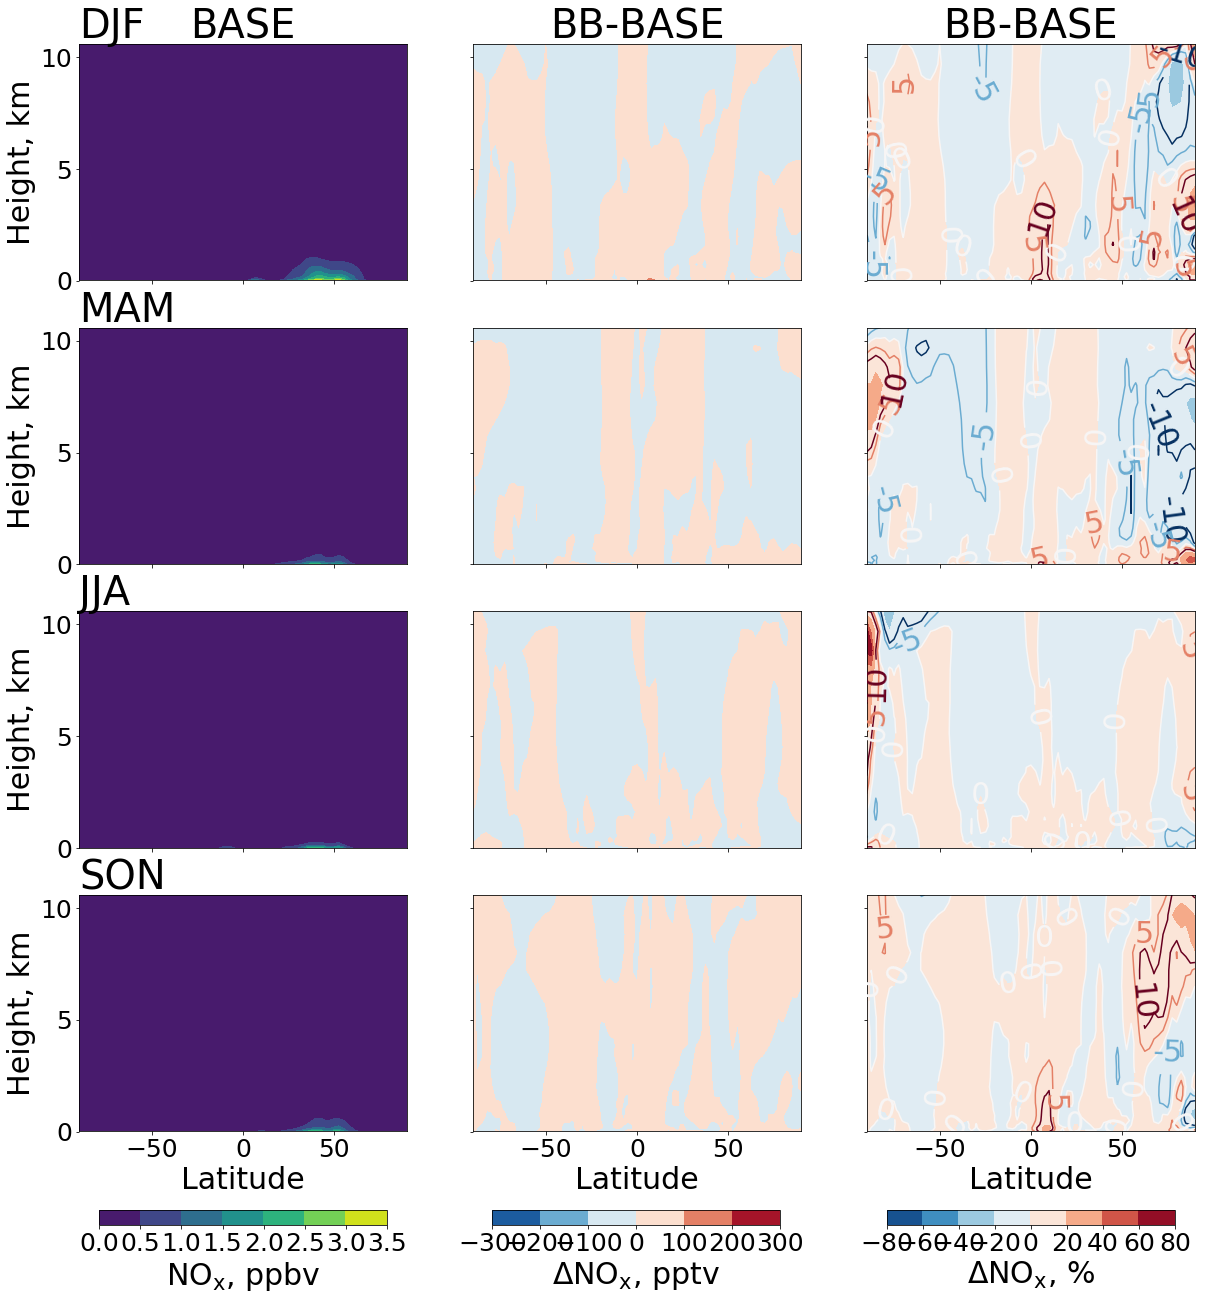

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20), facecolor='w', sharex=True, sharey=True)
p00 = ax[0,0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
p01 = ax[0,1].contourf(lats, levs, znl_djf_diff.data*1e3, **znl_glb_absdiff_pc_kwargs)
p02 = ax[0,2].contourf(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p02x = ax[0,2].contour(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_mean_cr_kwargs)
ax[0,2].clabel(p02x, inline=1, fmt='%1.0f')
p01.cmap.set_under('w')
p01.cmap.set_over('w')

ax[1,0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
ax[1,1].contourf(lats, levs, znl_mam_diff.data*1e3, **znl_glb_absdiff_pc_kwargs)
ax[1,2].contourf(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p12x = ax[1,2].contour(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_mean_cr_kwargs)
ax[1,2].clabel(p12x, inline=1, fmt='%1.0f')

ax[2,0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
ax[2,1].contourf(lats, levs, znl_jja_diff.data*1e3, **znl_glb_absdiff_pc_kwargs)
ax[2,2].contourf(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p22x = ax[2,2].contour(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_mean_cr_kwargs)
ax[2,2].clabel(p22x, inline=1, fmt='%1.0f')

p30 = ax[3,0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
p31 = ax[3,1].contourf(lats, levs, znl_son_diff.data*1e3, **znl_glb_absdiff_pc_kwargs)
p32 = ax[3,2].contourf(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p32x = ax[3,2].contour(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_mean_cr_kwargs)
ax[3,2].clabel(p32x, inline=1, fmt='%1.0f')

cax0 = fig.add_axes([0.139, 0.06, 0.2, 0.01]) # 0.07 for bottom when not for presentation
cax1 = fig.add_axes([0.412, 0.06, 0.2, 0.01])
cax2 = fig.add_axes([0.686, 0.06, 0.2, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, pptv')#, format=FuncFormatter(custom_ctcklbls))
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
ax[0,0].set_title(f'{base_plt}', loc='center')
ax[0,1].set_title(f'{sens_plt}-{base_plt}', loc='center')
ax[0,2].set_title(f'{sens_plt}-{base_plt}', loc='center')
ax[0,0].set_title(f'{str_djf}', loc='left')
ax[1,0].set_title(f'{str_mam}', loc='left')
ax[2,0].set_title(f'{str_jja}', loc='left')
ax[3,0].set_title(f'{str_son}', loc='left')
for iax in ax[:,0].flatten(): iax.set_ylabel('Height, km')
for iax in ax[3,:].flatten(): iax.set_xlabel('Latitude')
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
# for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
# for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_ssn_mean_all_publ.png', bbox_inches='tight')

### Surface seasonal means

In [ ]:
# Extract time series of surface seasonal means
base_srf_djf = base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_djf = sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_mam = base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_mam = sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_jja = base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_jja = sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_son = base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_son = sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
# Check if surface seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlats = base.coord('latitude').shape[0]
nlons = base.coord('longitude').shape[0]
shapiro_srf_djf_p = np.empty([nlats,nlons])
shapiro_srf_mam_p = np.empty([nlats,nlons])
shapiro_srf_jja_p = np.empty([nlats,nlons])
shapiro_srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_srf_djf_p[i,j] = stats.shapiro(base_srf_djf.data[:,i,j] - sens_srf_djf.data[:,i,j])[1]
        shapiro_srf_mam_p[i,j] = stats.shapiro(base_srf_mam.data[:,i,j] - sens_srf_mam.data[:,i,j])[1]
        shapiro_srf_jja_p[i,j] = stats.shapiro(base_srf_jja.data[:,i,j] - sens_srf_jja.data[:,i,j])[1]
        shapiro_srf_son_p[i,j] = stats.shapiro(base_srf_son.data[:,i,j] - sens_srf_son.data[:,i,j])[1]
# See if surface seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
srf_djf_p = np.empty([nlats,nlons])
srf_mam_p = np.empty([nlats,nlons])
srf_jja_p = np.empty([nlats,nlons])
srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_srf_djf_p[i,j] > 0.05:
            srf_djf_p[i,j] = stats.ttest_rel(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        else: 
            srf_djf_p[i,j] = stats.wilcoxon(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        if shapiro_srf_mam_p[i,j] > 0.05:
            srf_mam_p[i,j] = stats.ttest_rel(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        else:
            srf_mam_p[i,j] = stats.wilcoxon(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        if shapiro_srf_jja_p[i,j] > 0.05:
            srf_jja_p[i,j] = stats.ttest_rel(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        else:
            srf_jja_p[i,j] = stats.wilcoxon(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        if shapiro_srf_son_p[i,j] > 0.05:
            srf_son_p[i,j] = stats.ttest_rel(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
        else:
            srf_son_p[i,j] = stats.wilcoxon(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
#         # Welch's t-test
#         srf_djf_p[i, j] = stats.ttest_ind(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j], equal_var=False)[1]
#         srf_mam_p[i, j] = stats.ttest_ind(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j], equal_var=False)[1]
#         srf_jja_p[i, j] = stats.ttest_ind(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j], equal_var=False)[1]
#         srf_son_p[i, j] = stats.ttest_ind(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j], equal_var=False)[1]
# Calculate surface seasonal mean differences
base_srf_djf_mean = base_srf_djf.collapsed('year', iris.analysis.MEAN)
base_srf_mam_mean = base_srf_mam.collapsed('year', iris.analysis.MEAN)
base_srf_jja_mean = base_srf_jja.collapsed('year', iris.analysis.MEAN)
base_srf_son_mean = base_srf_son.collapsed('year', iris.analysis.MEAN)
sens_srf_djf_mean = sens_srf_djf.collapsed('year', iris.analysis.MEAN)
sens_srf_mam_mean = sens_srf_mam.collapsed('year', iris.analysis.MEAN)
sens_srf_jja_mean = sens_srf_jja.collapsed('year', iris.analysis.MEAN)
sens_srf_son_mean = sens_srf_son.collapsed('year', iris.analysis.MEAN)
srf_djf_diff = sens_srf_djf_mean - base_srf_djf_mean
srf_mam_diff = sens_srf_mam_mean - base_srf_mam_mean
srf_jja_diff = sens_srf_jja_mean - base_srf_jja_mean
srf_son_diff = sens_srf_son_mean - base_srf_son_mean
# Add cyclic point for plotting on a global map
cyc_srf_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(srf_djf_diff.data, coord=srf_djf_diff.coord('longitude').points)
cyc_srf_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
cyc_srf_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
cyc_srf_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
cyc_base_srf_djf_mean = cartopy.util.add_cyclic_point(base_srf_djf_mean.data)
cyc_base_srf_mam_mean = cartopy.util.add_cyclic_point(base_srf_mam_mean.data)
cyc_base_srf_jja_mean = cartopy.util.add_cyclic_point(base_srf_jja_mean.data)
cyc_base_srf_son_mean = cartopy.util.add_cyclic_point(base_srf_son_mean.data)
# Find max surface seasonal mean
print(max(np.max(base_srf_djf_mean.data), np.max(sens_srf_djf_mean.data)))
print(max(np.max(base_srf_mam_mean.data), np.max(sens_srf_mam_mean.data)))
print(max(np.max(base_srf_jja_mean.data), np.max(sens_srf_jja_mean.data)))
print(max(np.max(base_srf_son_mean.data), np.max(sens_srf_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(srf_djf_p), fdr_threshold(srf_mam_p), fdr_threshold(srf_jja_p), fdr_threshold(srf_son_p))

xojnb: 34.307390625
21.497314453125
19.15440234375
23.134015625
FDR:  0.029834821299264333 0.02041940975948022 0.001960657024049748 0.02841686417486375

xojnc: 

In [ ]:
# Surface seasonal mean difference plotting parameters
srf_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,40,5))
srf_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
srf_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=0.2)
fdr_srf = True # turn FDR on/off
def stipple_srf(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
def plt_srf_ssn_mean(cyc_base_srf_ssn_mean, cyc_srf_ssn_diff, srf_ssn_diff, srf_ssn_p, str_ssn):
    fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
    p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_ssn_mean.data, **srf_mean_cf_kwargs)
    p01 = ax[1].contourf(cyclic_lons, lats, cyc_srf_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
    p02 = ax[2].contourf(cyclic_lons, lats, cyc_srf_ssn_diff.data/cyc_base_srf_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
    ax[0].set_title(f'{str_ssn}', loc='right')
    ax[1].set_title(f'{str_ssn}', loc='right')
    ax[2].set_title(f'{str_ssn}', loc='right')
    ax[0].set_title(f'{str_var}', loc='center')
    ax[1].set_title(f'$\Delta${str_var}', loc='center')
    ax[2].set_title(f'$\Delta${str_var}', loc='center')
    ax[0].set_title(f'{base_plt}', loc='left')
    ax[1].set_title(f'{sens_plt}-{base_plt}', loc='left')
    ax[2].set_title(f'{sens_plt}-{base_plt}', loc='left')
    cb00 = fig.colorbar(p00, ax=ax[0], shrink=0.3)
    cb01 = fig.colorbar(p01, ax=ax[1], shrink=0.3)
    cb02 = fig.colorbar(p02, ax=ax[2], shrink=0.3)
    cb00.ax.set_title('ppbv', pad=10, loc='left')
    cb01.ax.set_title('ppbv', pad=10, loc='left')
    cb02.ax.set_title('%', pad=10, loc='left')
    for iax in ax.flatten()[1:3]: iax.scatter(*stipple_srf(srf_ssn_diff, srf_ssn_p, fdr_srf), **srf_pval_sc_kwargs)
    for iax in ax.flatten():
        iax.coastlines()
        iax.set_global()
    fig.tight_layout()
    if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_ssn_mean_{str_ssn}.png', bbox_inches='tight')

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_djf_mean, cyc_srf_djf_diff, srf_djf_diff, srf_djf_p, str_djf)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_mam_mean, cyc_srf_mam_diff, srf_mam_diff, srf_mam_p, str_mam)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_jja_mean, cyc_srf_jja_diff, srf_jja_diff, srf_jja_p, str_jja)

In [ ]:
# plt_srf_ssn_mean(cyc_base_srf_son_mean, cyc_srf_son_diff, srf_son_diff, srf_son_p, str_son)

In [ ]:
# Find min and max absolute surface seasonal mean difference
print(min([np.min(cyc_srf_djf_diff.data), np.min(cyc_srf_mam_diff.data), np.min(cyc_srf_jja_diff.data), np.min(cyc_srf_son_diff.data)]))
print(max([np.max(cyc_srf_djf_diff.data), np.max(cyc_srf_mam_diff.data), np.max(cyc_srf_jja_diff.data), np.max(cyc_srf_son_diff.data)]))
# Find min and max % surface seasonal mean difference
print(min([np.min(cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100), np.min(cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100), 
           np.min(cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100), np.min(cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100)]))
print(max([np.max(cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100), np.max(cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100), 
           np.max(cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100), np.max(cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100)]))

xojnb: -2.2958355
1.5982037
-50.968243
169.65215

xojnc: 

In [ ]:
# Additional plotting parameteres for surface seasonal mean summary
srf_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-3,4,1))
srf_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-180,200,20))#, extend='both')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_srf_djf_diff.data/cyc_base_srf_djf_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_srf_mam_diff.data/cyc_base_srf_mam_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_srf_jja_diff.data/cyc_base_srf_jja_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_srf_son_diff.data, **srf_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_srf_son_diff.data/cyc_base_srf_son_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
fig.text(0.02, 0.31, 'SON')#, fontsize=12)
fig.suptitle('Surface', y=0.9, weight='bold')
ax[0,0].set_title(f'{base_plt}')
ax[0,1].set_title(f'{sens_plt}-{base_plt}')
ax[0,2].set_title(f'{sens_plt}-{base_plt}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_all.png', bbox_inches='tight')

#### Boundary layer seasonal means

In [25]:
# Find 0-2 km level height range
base.coord('level_height')[0:10].points

array([  19.998281,   80.00153 ,  180.00136 ,  319.99774 ,  499.99908 ,
        719.997   ,  979.9999  , 1279.9994  , 1620.0038  , 1999.9963  ],
      dtype=float32)

In [26]:
# Extract time series of boundary layer (0-2 km) seasonal means
base_pbl_djf = (base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_djf = (sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_mam = (base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_mam = (sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_jja = (base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_jja = (sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
base_pbl_son = (base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
sens_pbl_son = (sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0:10,...]).collapsed('level_height', iris.analysis.MEAN)
# Check if boundary layer seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlons = base.coord('longitude').shape[0]
shapiro_pbl_djf_p = np.empty([nlats,nlons])
shapiro_pbl_mam_p = np.empty([nlats,nlons])
shapiro_pbl_jja_p = np.empty([nlats,nlons])
shapiro_pbl_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_pbl_djf_p[i,j] = stats.shapiro(base_pbl_djf.data[:,i,j] - sens_pbl_djf.data[:,i,j])[1]
        shapiro_pbl_mam_p[i,j] = stats.shapiro(base_pbl_mam.data[:,i,j] - sens_pbl_mam.data[:,i,j])[1]
        shapiro_pbl_jja_p[i,j] = stats.shapiro(base_pbl_jja.data[:,i,j] - sens_pbl_jja.data[:,i,j])[1]
        shapiro_pbl_son_p[i,j] = stats.shapiro(base_pbl_son.data[:,i,j] - sens_pbl_son.data[:,i,j])[1]
# See if boundary layer seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
pbl_djf_p = np.empty([nlats,nlons])
pbl_mam_p = np.empty([nlats,nlons])
pbl_jja_p = np.empty([nlats,nlons])
pbl_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_pbl_djf_p[i,j] > 0.05:
            pbl_djf_p[i,j] = stats.ttest_rel(base_pbl_djf.data[:,i,j], sens_pbl_djf.data[:,i,j])[1]
        else: 
            pbl_djf_p[i,j] = stats.wilcoxon(base_pbl_djf.data[:,i,j], sens_pbl_djf.data[:,i,j])[1]
        if shapiro_pbl_mam_p[i,j] > 0.05:
            pbl_mam_p[i,j] = stats.ttest_rel(base_pbl_mam.data[:,i,j], sens_pbl_mam.data[:,i,j])[1]
        else:
            pbl_mam_p[i,j] = stats.wilcoxon(base_pbl_mam.data[:,i,j], sens_pbl_mam.data[:,i,j])[1]
        if shapiro_pbl_jja_p[i,j] > 0.05:
            pbl_jja_p[i,j] = stats.ttest_rel(base_pbl_jja.data[:,i,j], sens_pbl_jja.data[:,i,j])[1]
        else:
            pbl_jja_p[i,j] = stats.wilcoxon(base_pbl_jja.data[:,i,j], sens_pbl_jja.data[:,i,j])[1]
        if shapiro_pbl_son_p[i,j] > 0.05:
            pbl_son_p[i,j] = stats.ttest_rel(base_pbl_son.data[:,i,j], sens_pbl_son.data[:,i,j])[1]
        else:
            pbl_son_p[i,j] = stats.wilcoxon(base_pbl_son.data[:,i,j], sens_pbl_son.data[:,i,j])[1]
#         # Welch's t-test
#         pbl_djf_p[i, j] = stats.ttest_ind(base_pbl_djf.data[:,i,j], sens_pbl_djf.data[:,i,j], equal_var=False)[1]
#         pbl_mam_p[i, j] = stats.ttest_ind(base_pbl_mam.data[:,i,j], sens_pbl_mam.data[:,i,j], equal_var=False)[1]
#         pbl_jja_p[i, j] = stats.ttest_ind(base_pbl_jja.data[:,i,j], sens_pbl_jja.data[:,i,j], equal_var=False)[1]
#         pbl_son_p[i, j] = stats.ttest_ind(base_pbl_son.data[:,i,j], sens_pbl_son.data[:,i,j], equal_var=False)[1]
# Calculate boundary layer seasonal mean differences
base_pbl_djf_mean = base_pbl_djf.collapsed('year', iris.analysis.MEAN)
base_pbl_mam_mean = base_pbl_mam.collapsed('year', iris.analysis.MEAN)
base_pbl_jja_mean = base_pbl_jja.collapsed('year', iris.analysis.MEAN)
base_pbl_son_mean = base_pbl_son.collapsed('year', iris.analysis.MEAN)
sens_pbl_djf_mean = sens_pbl_djf.collapsed('year', iris.analysis.MEAN)
sens_pbl_mam_mean = sens_pbl_mam.collapsed('year', iris.analysis.MEAN)
sens_pbl_jja_mean = sens_pbl_jja.collapsed('year', iris.analysis.MEAN)
sens_pbl_son_mean = sens_pbl_son.collapsed('year', iris.analysis.MEAN)
pbl_djf_diff = sens_pbl_djf_mean - base_pbl_djf_mean
pbl_mam_diff = sens_pbl_mam_mean - base_pbl_mam_mean
pbl_jja_diff = sens_pbl_jja_mean - base_pbl_jja_mean
pbl_son_diff = sens_pbl_son_mean - base_pbl_son_mean
# Add cyclic point for plotting on a global map
cyc_pbl_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(pbl_djf_diff.data, coord=pbl_djf_diff.coord('longitude').points)
cyc_pbl_mam_diff = cartopy.util.add_cyclic_point(pbl_mam_diff.data)
cyc_pbl_jja_diff = cartopy.util.add_cyclic_point(pbl_jja_diff.data)
cyc_pbl_son_diff = cartopy.util.add_cyclic_point(pbl_son_diff.data)
cyc_base_pbl_djf_mean = cartopy.util.add_cyclic_point(base_pbl_djf_mean.data)
cyc_base_pbl_mam_mean = cartopy.util.add_cyclic_point(base_pbl_mam_mean.data)
cyc_base_pbl_jja_mean = cartopy.util.add_cyclic_point(base_pbl_jja_mean.data)
cyc_base_pbl_son_mean = cartopy.util.add_cyclic_point(base_pbl_son_mean.data)
# Find max boundary layer seasonal mean
print(max(np.max(base_pbl_djf_mean.data), np.max(sens_pbl_djf_mean.data)))
print(max(np.max(base_pbl_mam_mean.data), np.max(sens_pbl_mam_mean.data)))
print(max(np.max(base_pbl_jja_mean.data), np.max(sens_pbl_jja_mean.data)))
print(max(np.max(base_pbl_son_mean.data), np.max(sens_pbl_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(pbl_djf_p), fdr_threshold(pbl_mam_p), fdr_threshold(pbl_jja_p), fdr_threshold(pbl_son_p))

12.408577
4.7024164
4.223668
7.0483484
FDR:  0.00018745086094982505 1.4662165195776532e-05 0.0 0.0006162709270301145


xojnb: 12.408578
4.6978154
4.3129826
7.0483484
FDR:  0.031086936638305387 0.022062642888019564 0.0018451011126558632 0.029874414510478165

xojnc: 12.408577
4.7024164
4.223668
7.0483484
FDR:  0.00018745086094982505 1.4662165195776532e-05 0.0 0.0006162709270301145

In [27]:
# Boundary layer seasonal mean difference plotting parameters
pbl_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,16,2))
pbl_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
pbl_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=1)
fdr_pbl = True # turn FDR on/off
def stipple_pbl(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
def plt_pbl_ssn_mean(cyc_base_pbl_ssn_mean, cyc_pbl_ssn_diff, pbl_ssn_diff, pbl_ssn_p, str_ssn):
    fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
    p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_pbl_ssn_mean.data, **pbl_mean_cf_kwargs)
    p01 = ax[1].contourf(cyclic_lons, lats, cyc_pbl_ssn_diff.data, norm=MidpointNormalize(midpoint=0.), **pbl_diff_cf_kwargs)
    p02 = ax[2].contourf(cyclic_lons, lats, cyc_pbl_ssn_diff.data/cyc_base_pbl_ssn_mean.data*100, norm=MidpointNormalize(midpoint=0.), **pbl_diff_cf_kwargs)
    ax[0].set_title(f'{str_ssn}', loc='right')
    ax[1].set_title(f'{str_ssn}', loc='right')
    ax[2].set_title(f'{str_ssn}', loc='right')
    ax[0].set_title(f'{str_var}', loc='center')
    ax[1].set_title(f'$\Delta${str_var}', loc='center')
    ax[2].set_title(f'$\Delta${str_var}', loc='center')
    ax[0].set_title(f'{base_plt}', loc='left')
    ax[1].set_title(f'{sens_plt}-{base_plt}', loc='left')
    ax[2].set_title(f'{sens_plt}-{base_plt}', loc='left')
    cb00 = fig.colorbar(p00, ax=ax[0], shrink=0.3)
    cb01 = fig.colorbar(p01, ax=ax[1], shrink=0.3)
    cb02 = fig.colorbar(p02, ax=ax[2], shrink=0.3)
    cb00.ax.set_title('ppbv', pad=10, loc='left')
    cb01.ax.set_title('ppbv', pad=10, loc='left')
    cb02.ax.set_title('%', pad=10, loc='left')
    for iax in ax.flatten()[1:3]: iax.scatter(*stipple_pbl(pbl_ssn_diff, pbl_ssn_p, fdr_pbl), **pbl_pval_sc_kwargs)
    for iax in ax.flatten():
        iax.coastlines()
        iax.set_global()
    fig.tight_layout()
    if savefig: fig.savefig(path_to_figs / f'{dir_var}_pbl_ssn_mean_{str_ssn}.png', bbox_inches='tight')

In [ ]:
# plt_pbl_ssn_mean(cyc_base_pbl_djf_mean, cyc_pbl_djf_diff, pbl_djf_diff, pbl_djf_p, str_djf)

In [ ]:
# plt_pbl_ssn_mean(cyc_base_pbl_mam_mean, cyc_pbl_mam_diff, pbl_mam_diff, pbl_mam_p, str_mam)

In [ ]:
# plt_pbl_ssn_mean(cyc_base_pbl_jja_mean, cyc_pbl_jja_diff, pbl_jja_diff, pbl_jja_p, str_jja)

In [ ]:
# plt_pbl_ssn_mean(cyc_base_pbl_son_mean, cyc_pbl_son_diff, pbl_son_diff, pbl_son_p, str_son)

In [28]:
# Find min and max absolute boundary layer seasonal mean difference
print(min([np.min(cyc_pbl_djf_diff.data), np.min(cyc_pbl_mam_diff.data), np.min(cyc_pbl_jja_diff.data), np.min(cyc_pbl_son_diff.data)]))
print(max([np.max(cyc_pbl_djf_diff.data), np.max(cyc_pbl_mam_diff.data), np.max(cyc_pbl_jja_diff.data), np.max(cyc_pbl_son_diff.data)]))
# Find min and max % boundary layer seasonal mean difference
print(min([np.min(cyc_pbl_djf_diff.data/cyc_base_pbl_djf_mean.data*100), np.min(cyc_pbl_mam_diff.data/cyc_base_pbl_mam_mean.data*100), 
           np.min(cyc_pbl_jja_diff.data/cyc_base_pbl_jja_mean.data*100), np.min(cyc_pbl_son_diff.data/cyc_base_pbl_son_mean.data*100)]))
print(max([np.max(cyc_pbl_djf_diff.data/cyc_base_pbl_djf_mean.data*100), np.max(cyc_pbl_mam_diff.data/cyc_base_pbl_mam_mean.data*100), 
           np.max(cyc_pbl_jja_diff.data/cyc_base_pbl_jja_mean.data*100), np.max(cyc_pbl_son_diff.data/cyc_base_pbl_son_mean.data*100)]))

-0.6207614
1.0519629
-38.703545
84.21026


xojnb: -0.7482295
0.63434696
-45.215973
151.6376

xojnc: -0.6207614
1.0519629
-38.703545
84.21026

In [29]:
# Additional plotting parameteres for boundary layer seasonal mean summary
# b -1,1.2,0.2, -160,180,40
# c 
pbl_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-0.8,1,0.2))
pbl_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-100,120,20))

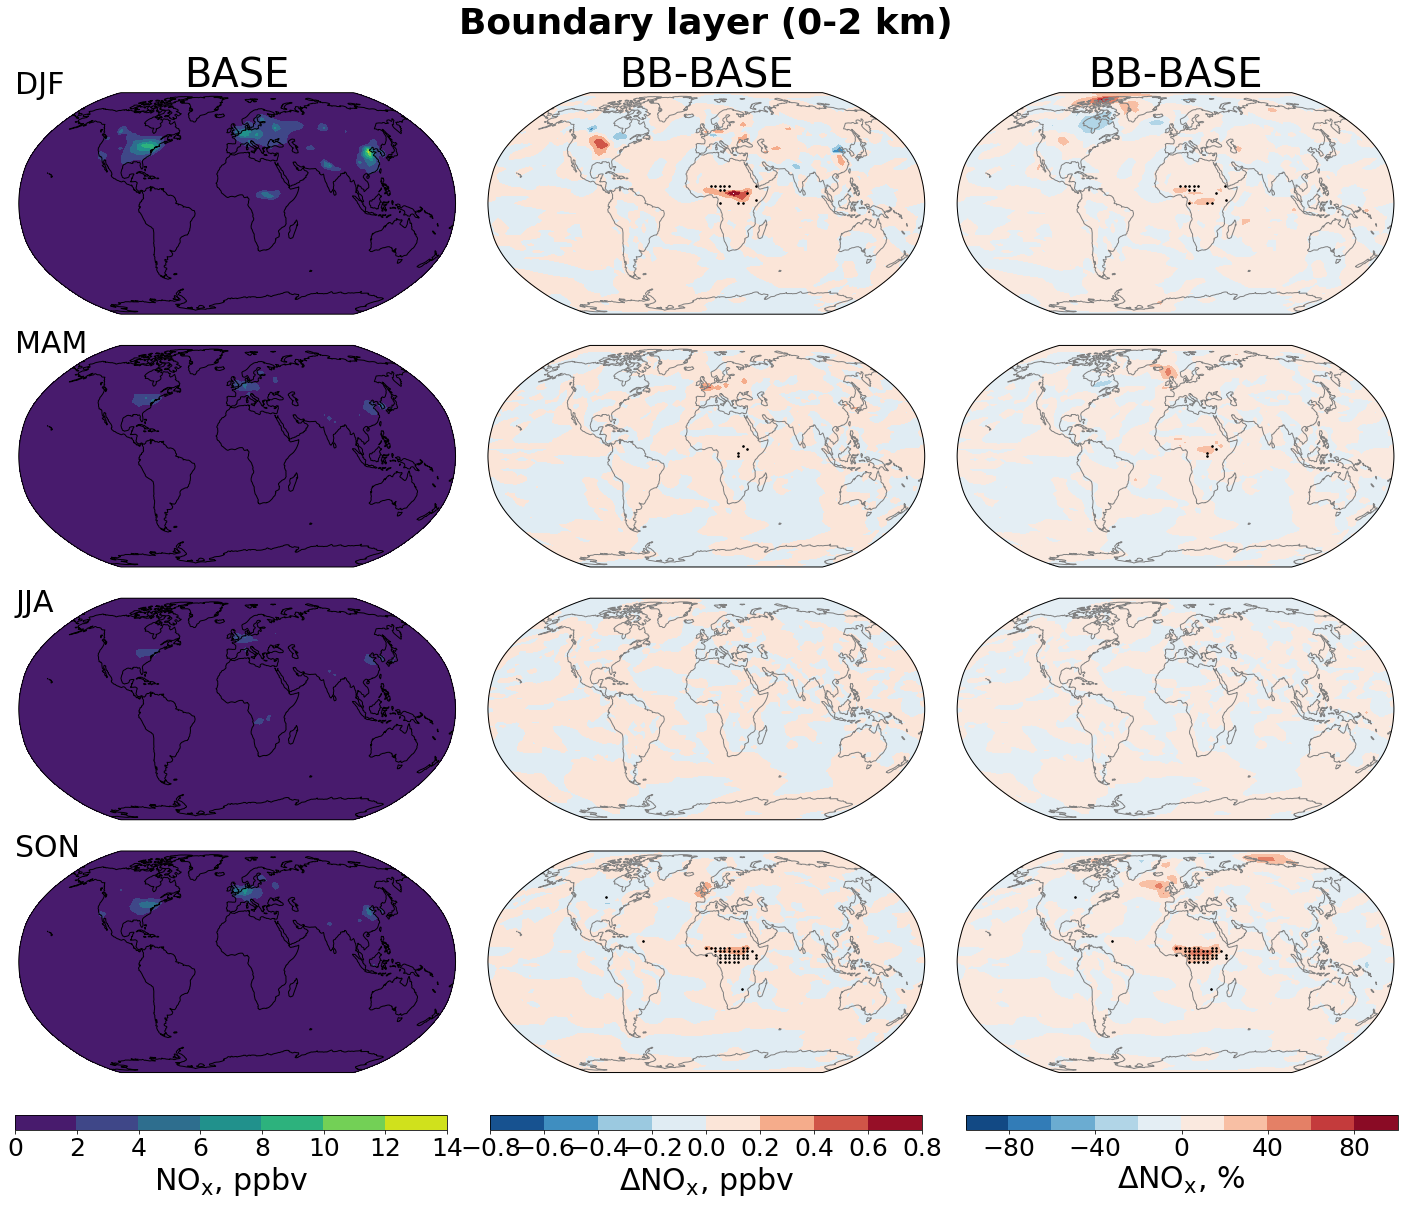

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_pbl_djf_mean.data, **pbl_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_pbl_djf_diff.data, **pbl_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_pbl_djf_diff.data/cyc_base_pbl_djf_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_pbl_mam_mean.data, **pbl_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_pbl_mam_diff.data, **pbl_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_pbl_mam_diff.data/cyc_base_pbl_mam_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_pbl_jja_mean.data, **pbl_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_pbl_jja_diff.data, **pbl_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_pbl_jja_diff.data/cyc_base_pbl_jja_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_pbl_son_mean.data, **pbl_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_pbl_son_diff.data, **pbl_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_pbl_son_diff.data/cyc_base_pbl_son_mean.data*100, **pbl_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
fig.text(0.02, 0.31, 'SON')#, fontsize=12)
fig.suptitle('Boundary layer (0-2 km)', y=0.9, weight='bold')
ax[0,0].set_title(f'{base_plt}')
ax[0,1].set_title(f'{sens_plt}-{base_plt}')
ax[0,2].set_title(f'{sens_plt}-{base_plt}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_pbl(pbl_djf_diff, pbl_djf_p, fdr_pbl), **pbl_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_pbl(pbl_mam_diff, pbl_mam_p, fdr_pbl), **pbl_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_pbl(pbl_jja_diff, pbl_jja_p, fdr_pbl), **pbl_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_pbl(pbl_son_diff, pbl_son_p, fdr_pbl), **pbl_pval_sc_kwargs)
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{dir_var}_pbl_seas_mean_all_publ.png', bbox_inches='tight')

#### Free troposphere seasonal means

In [ ]:
# Find 5-10 km level height range
base.coord('level_height')[15:23].points/1000

In [ ]:
# Extract time series of free troposphere (5-10 km) seasonal means
base_fre_djf = (base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_djf = (sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_mam = (base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_mam = (sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_jja = (base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_jja = (sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
base_fre_son = (base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
sens_fre_son = (sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,15:23,...]).collapsed('level_height', iris.analysis.MEAN)
# Check if free troposphere seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
shapiro_fre_djf_p = np.empty([nlats,nlons])
shapiro_fre_mam_p = np.empty([nlats,nlons])
shapiro_fre_jja_p = np.empty([nlats,nlons])
shapiro_fre_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_fre_djf_p[i,j] = stats.shapiro(base_fre_djf.data[:,i,j] - sens_fre_djf.data[:,i,j])[1]
        shapiro_fre_mam_p[i,j] = stats.shapiro(base_fre_mam.data[:,i,j] - sens_fre_mam.data[:,i,j])[1]
        shapiro_fre_jja_p[i,j] = stats.shapiro(base_fre_jja.data[:,i,j] - sens_fre_jja.data[:,i,j])[1]
        shapiro_fre_son_p[i,j] = stats.shapiro(base_fre_son.data[:,i,j] - sens_fre_son.data[:,i,j])[1]
# See if free troposphere seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
fre_djf_p = np.empty([nlats,nlons])
fre_mam_p = np.empty([nlats,nlons])
fre_jja_p = np.empty([nlats,nlons])
fre_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_fre_djf_p[i,j] > 0.05:
            fre_djf_p[i,j] = stats.ttest_rel(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j])[1]
        else: 
            fre_djf_p[i,j] = stats.wilcoxon(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j])[1]
        if shapiro_fre_mam_p[i,j] > 0.05:
            fre_mam_p[i,j] = stats.ttest_rel(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j])[1]
        else:
            fre_mam_p[i,j] = stats.wilcoxon(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j])[1]
        if shapiro_fre_jja_p[i,j] > 0.05:
            fre_jja_p[i,j] = stats.ttest_rel(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j])[1]
        else:
            fre_jja_p[i,j] = stats.wilcoxon(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j])[1]
        if shapiro_fre_son_p[i,j] > 0.05:
            fre_son_p[i,j] = stats.ttest_rel(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j])[1]
        else:
            fre_son_p[i,j] = stats.wilcoxon(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j])[1]
#         # Welch's t-test
#         fre_djf_p[i, j] = stats.ttest_ind(base_fre_djf.data[:,i,j], sens_fre_djf.data[:,i,j], equal_var=False)[1]
#         fre_mam_p[i, j] = stats.ttest_ind(base_fre_mam.data[:,i,j], sens_fre_mam.data[:,i,j], equal_var=False)[1]
#         fre_jja_p[i, j] = stats.ttest_ind(base_fre_jja.data[:,i,j], sens_fre_jja.data[:,i,j], equal_var=False)[1]
#         fre_son_p[i, j] = stats.ttest_ind(base_fre_son.data[:,i,j], sens_fre_son.data[:,i,j], equal_var=False)[1]
# Calculate free troposphere seasonal mean differences
base_fre_djf_mean = base_fre_djf.collapsed('year', iris.analysis.MEAN)
base_fre_mam_mean = base_fre_mam.collapsed('year', iris.analysis.MEAN)
base_fre_jja_mean = base_fre_jja.collapsed('year', iris.analysis.MEAN)
base_fre_son_mean = base_fre_son.collapsed('year', iris.analysis.MEAN)
sens_fre_djf_mean = sens_fre_djf.collapsed('year', iris.analysis.MEAN)
sens_fre_mam_mean = sens_fre_mam.collapsed('year', iris.analysis.MEAN)
sens_fre_jja_mean = sens_fre_jja.collapsed('year', iris.analysis.MEAN)
sens_fre_son_mean = sens_fre_son.collapsed('year', iris.analysis.MEAN)
fre_djf_diff = sens_fre_djf_mean - base_fre_djf_mean
fre_mam_diff = sens_fre_mam_mean - base_fre_mam_mean
fre_jja_diff = sens_fre_jja_mean - base_fre_jja_mean
fre_son_diff = sens_fre_son_mean - base_fre_son_mean
# Add cyclic point for plotting on a global map
cyc_fre_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(fre_djf_diff.data, coord=fre_djf_diff.coord('longitude').points)
cyc_fre_mam_diff = cartopy.util.add_cyclic_point(fre_mam_diff.data)
cyc_fre_jja_diff = cartopy.util.add_cyclic_point(fre_jja_diff.data)
cyc_fre_son_diff = cartopy.util.add_cyclic_point(fre_son_diff.data)
cyc_base_fre_djf_mean = cartopy.util.add_cyclic_point(base_fre_djf_mean.data)
cyc_base_fre_mam_mean = cartopy.util.add_cyclic_point(base_fre_mam_mean.data)
cyc_base_fre_jja_mean = cartopy.util.add_cyclic_point(base_fre_jja_mean.data)
cyc_base_fre_son_mean = cartopy.util.add_cyclic_point(base_fre_son_mean.data)
# Find max free troposphere seasonal mean
print(max(np.max(base_fre_djf_mean.data), np.max(sens_fre_djf_mean.data)))
print(max(np.max(base_fre_mam_mean.data), np.max(sens_fre_mam_mean.data)))
print(max(np.max(base_fre_jja_mean.data), np.max(sens_fre_jja_mean.data)))
print(max(np.max(base_fre_son_mean.data), np.max(sens_fre_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(fre_djf_p), fdr_threshold(fre_mam_p), fdr_threshold(fre_jja_p), fdr_threshold(fre_son_p))

xojnb: 120.777016
143.42606
103.412575
98.72422
FDR:  0.0 0.0 0.0 0.0

xojnc: 121.10372
143.42606
103.412575
98.65314
FDR:  0.0 0.0 0.0 0.0

In [ ]:
# Free troposphere seasonal mean difference plotting parameters
fre_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,175,25))
fre_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
fre_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=0.2)
fdr_fre = True # turn FDR on/off
def stipple_fre(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
# Find min and max absolute free troposphere seasonal mean difference
print(min([np.min(cyc_fre_djf_diff.data), np.min(cyc_fre_mam_diff.data), np.min(cyc_fre_jja_diff.data), np.min(cyc_fre_son_diff.data)]))
print(max([np.max(cyc_fre_djf_diff.data), np.max(cyc_fre_mam_diff.data), np.max(cyc_fre_jja_diff.data), np.max(cyc_fre_son_diff.data)]))
# Find min and max % free troposphere seasonal mean difference
print(min([np.min(cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100), np.min(cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100), 
           np.min(cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100), np.min(cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100)]))
print(max([np.max(cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100), np.max(cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100), 
           np.max(cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100), np.max(cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100)]))

xojnb: -6.1123123
9.220947
-12.65836
11.857278

xojnc: -7.031479
11.983612
-10.37066
12.530851

In [ ]:
# Additional plotting parameteres for free troposphere seasonal mean summary
fre_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-12,14,2))
fre_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-14,16,2))#, extend='both')

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_fre_djf_mean.data, **fre_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_fre_djf_diff.data/cyc_base_fre_djf_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_fre_mam_mean.data, **fre_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_fre_mam_diff.data/cyc_base_fre_mam_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_fre_jja_mean.data, **fre_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data, **fre_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_fre_jja_diff.data/cyc_base_fre_jja_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_fre_son_mean.data, **fre_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_fre_son_diff.data, **fre_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_fre_son_diff.data/cyc_base_fre_son_mean.data*100, **fre_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF')#, fontsize=12)
fig.text(0.02, 0.66, 'MAM')#, fontsize=12)
fig.text(0.02, 0.48, 'JJA')#, fontsize=12)
fig.text(0.02, 0.31, 'SON')#, fontsize=12)
fig.suptitle('Free troposphere (5-10 km)', y=0.9, weight='bold')
ax[0,0].set_title(f'{base_plt}')
ax[0,1].set_title(f'{sens_plt}-{base_plt}')
ax[0,2].set_title(f'{sens_plt}-{base_plt}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_fre(fre_djf_diff, fre_djf_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_fre(fre_mam_diff, fre_mam_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_fre(fre_jja_diff, fre_jja_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_fre(fre_son_diff, fre_son_p, fdr_fre), **fre_pval_sc_kwargs)
for iax in ax.flatten(): iax.set_global()
for iax in ax[:,0].flatten(): iax.coastlines(color='k')
for iax in ax[0:4,1:].flatten(): iax.coastlines(color='grey')
if savefig: fig.savefig(path_to_figs / f'{dir_var}_fre_seas_mean_all.png', bbox_inches='tight')

In [ ]:
# # Add cyclic points for stippling
# _cyc_srf_djf_diff = cartopy.util.add_cyclic_point(srf_djf_diff.data)
# _cyc_srf_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
# _cyc_srf_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
# _cyc_srf_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
# cyclic_lons_coord = iris.coords.DimCoord(cyclic_lons, standard_name='longitude')
# cyc_srf_djf_diff = iris.cube.Cube(data=_cyc_srf_djf_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_mam_diff = iris.cube.Cube(data=_cyc_srf_mam_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_jja_diff = iris.cube.Cube(data=_cyc_srf_jja_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_son_diff = iris.cube.Cube(data=_cyc_srf_son_diff, dim_coords_and_dims=[(base.coord('latitude'), 0), (cyclic_lons_coord, 1)])
# cyc_srf_djf_p = np.append(srf_djf_p, srf_djf_p[:,0].reshape(srf_djf_p.shape[0], 1), axis=1)
# cyc_srf_mam_p = np.append(srf_mam_p, srf_mam_p[:,0].reshape(srf_mam_p.shape[0], 1), axis=1)
# cyc_srf_jja_p = np.append(srf_jja_p, srf_jja_p[:,0].reshape(srf_jja_p.shape[0], 1), axis=1)
# cyc_srf_son_p = np.append(srf_son_p, srf_son_p[:,0].reshape(srf_son_p.shape[0], 1), axis=1)